<a href="https://colab.research.google.com/github/StarDylan/FlowMatching/blob/main/MNIST_Full_Flow_Matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Part 1: Flow on MNIST Dataset trying to follow [here](https://github.com/facebookresearch/flow_matching/blob/main/examples/2d_flow_matching.ipynb)

In [ ]:
!pip install flow_matching > /dev/null 2>&1

In [ ]:
# From https://github.com/Michedev/flow-matching-mnist/blob/main/unet.py
import torch
import torch.nn as nn
import torch.nn.functional as F

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.embedding_l = nn.Linear(3, dim)

    def forward(self, time):
        device = time.device
        time = torch.cat([time, torch.cos(time), torch.sin(time)], dim=-1)
        return self.embedding_l(time)

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.SiLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.SiLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, c=64):
        super().__init__()

        # Time embeddings for each skip connection
        self.time_mlp1 = nn.Sequential(
            SinusoidalPositionEmbeddings(c),
            nn.Linear(c, c),
            nn.SiLU(),
            nn.Linear(c, c)
        )

        self.time_mlp2 = nn.Sequential(
            SinusoidalPositionEmbeddings(c),
            nn.Linear(c, 2*c),
            nn.SiLU(),
            nn.Linear(2*c, 2*c)
        )

        self.time_mlp3 = nn.Sequential(
            SinusoidalPositionEmbeddings(c),
            nn.Linear(c, 4*c),
            nn.SiLU(),
            nn.Linear(4*c, 4*c)
        )

        # Encoder
        self.conv1 = DoubleConv(in_channels, c)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(c, 2*c)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(2*c, 4*c)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = DoubleConv(4*c, 8*c)

        # Decoder
        self.upconv3 = nn.ConvTranspose2d(8*c, 4*c, kernel_size=2, stride=2)
        self.conv5 = DoubleConv(12*c, 4*c)  # 4c + 4c + 4c (skip + up + time)
        self.upconv2 = nn.ConvTranspose2d(4*c, 2*c, kernel_size=2, stride=2)
        self.conv6 = DoubleConv(6*c, 2*c)   # 2c + 2c + 2c
        self.upconv1 = nn.ConvTranspose2d(2*c, c, kernel_size=2, stride=2)
        self.conv7 = DoubleConv(3*c, c)     # c + c + c

        self.final_conv = nn.Conv2d(c, out_channels, kernel_size=1)


    def forward(self, x, t):
        # Time embeddings
        t = t.view(-1, 1)
        if t.numel() == 1:
            t = t.expand(x.shape[0], -1)
        t1 = self.time_mlp1(t)        # Shape: [batch, c]
        t2 = self.time_mlp2(t)        # Shape: [batch, 2c]
        t3 = self.time_mlp3(t)        # Shape: [batch, 4c]

        # Encoder
        conv1 = self.conv1(x)                 # Shape: [batch, c, H, W]
        pool1 = self.pool1(conv1)             # Shape: [batch, c, H/2, W/2]

        conv2 = self.conv2(pool1)             # Shape: [batch, 2c, H/2, W/2]
        pool2 = self.pool2(conv2)             # Shape: [batch, 2c, H/4, W/4]

        conv3 = self.conv3(pool2)             # Shape: [batch, 4c, H/4, W/4]
        pool3 = self.pool3(conv3)             # Shape: [batch, 4c, H/8, W/8]

        conv4 = self.conv4(pool3)             # Shape: [batch, 8c, H/8, W/8]

        # Helper function for padding
        def pad_if_needed(upsampled, skip):
            if (upsampled.shape[-1] + 1) == skip.shape[-1]:
                return F.pad(upsampled, (0, 1, 0, 1), mode='replicate')
            return upsampled
        # Decoder Step 1
        up3 = self.upconv3(conv4)              # Shape: [batch, 4c, H/4, W/4]
        up3 = pad_if_needed(up3, conv3)        # Ensure up3 matches conv3 dimensions
        # Reshape t3 to [batch, 4c, H/4, W/4]
        t_emb3 = t3.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, up3.size(2), up3.size(3))
        # Alternatively, use expand to save memory:
        # t_emb3 = t3.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, up3.size(2), up3.size(3))
        concat3 = torch.cat([up3, conv3, t_emb3], dim=1)   # Shape: [batch, 12c, H/4, W/4]
        conv5 = self.conv5(concat3)            # Shape: [batch, 4c, H/4, W/4]

        # Decoder Step 2
        up2 = self.upconv2(conv5)              # Shape: [batch, 2c, H/2, W/2]
        up2 = pad_if_needed(up2, conv2)        # Ensure up2 matches conv2 dimensions
        # Reshape t2 to [batch, 2c, H/2, W/2]
        t_emb2 = t2.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, up2.size(2), up2.size(3))
        concat2 = torch.cat([up2, conv2, t_emb2], dim=1)   # Shape: [batch, 6c, H/2, W/2]
        conv6 = self.conv6(concat2)            # Shape: [batch, 2c, H/2, W/2]

        # Decoder Step 3
        up1 = self.upconv1(conv6)              # Shape: [batch, c, H, W]
        up1 = pad_if_needed(up1, conv1)        # Ensure up1 matches conv1 dimensions
        # Reshape t1 to [batch, c, H, W]
        t_emb1 = t1.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, up1.size(2), up1.size(3))
        concat1 = torch.cat([up1, conv1, t_emb1], dim=1)   # Shape: [batch, 3c, H, W]
        conv7 = self.conv7(concat1)            # Shape: [batch, c, H, W]

        # Final Convolution
        return self.final_conv(conv7)          # Shape: [batch, out_channels, H, W]

In [ ]:
import torch
from tensorflow.keras.datasets import mnist
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt

In [ ]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print('Using gpu')
else:
    device = 'cpu'
    print('Using cpu.')

Using gpu


In [ ]:
def get_mnist_data():
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  x_train = x_train.astype('float32')
  x_train /= 255
  x_train = x_train * 2 - 1
  x_test = x_test.astype('float32')
  x_test /= 255
  x_test = x_test * 2 - 1
  return x_train, y_train, x_test, y_test

In [ ]:
X_train, y_train, X_test, y_test = get_mnist_data()

In [ ]:
X_train.shape

(60000, 28, 28)

(60000, 28, 28)


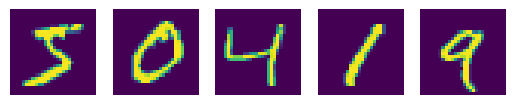

In [ ]:
print(X_train.shape)
for i in range(5):
  plt.subplot(1, 5, i+1)
  plt.imshow(X_train[i])
  plt.axis('off')
plt.show()

In [ ]:
import time
import torch

from torch import nn, Tensor

# flow_matching
from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.path import AffineProbPath
from flow_matching.solver import Solver, ODESolver
from flow_matching.utils import ModelWrapper

# visualization
import matplotlib.pyplot as plt

from matplotlib import cm


# To avoide meshgrid warning
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module='torch')

In [ ]:
# training arguments
lr = 0.001
batch_size = 500
iterations = 17000 # 20001
print_every = 500
hidden_dim = 512
noise_level = 0.8

In [ ]:
X = X_train
X=torch.tensor(X).to(device)
X = X.unsqueeze(1)  # Now shape is [60000, 1, 28, 28]
X = X.to(device)
print("X.shape", X.shape)

X.shape torch.Size([60000, 1, 28, 28])


In [ ]:
# velocity field model init
vf = UNet(1, 1).to(device)

# instantiate an affine path object
path = AffineProbPath(scheduler=CondOTScheduler())

# init optimizer
optim = torch.optim.Adam(vf.parameters(), lr=lr)

# train
start_time = time.time()
for i in range(iterations):
    optim.zero_grad()

    # sample data (user's responsibility)
    idx = torch.randperm(X.size(0))[:batch_size]
    x_1 = X[idx].float()
    x_0 = torch.randn_like(x_1).to(device)

    # sample time (user's responsibility)
    t = torch.rand(x_1.shape[0]).to(device)
    # print(f"t.shape {t.shape}")

    # sample probability path
    path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)

    # flow matching l2 loss
    loss = torch.pow( vf(path_sample.x_t,path_sample.t) - path_sample.dx_t, 2).mean()

    # optimizer step
    loss.backward() # backward
    optim.step() # update

    # log loss
    if (i+1) % print_every == 0:
        elapsed = time.time() - start_time
        print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f} '
              .format(i+1, elapsed*1000/print_every, loss.item()))
        start_time = time.time()

| iter    500 | 329.09 ms/step | loss    0.299 
| iter   1000 | 328.83 ms/step | loss    0.233 
| iter   1500 | 327.60 ms/step | loss    0.244 
| iter   2000 | 327.39 ms/step | loss    0.220 
| iter   2500 | 330.85 ms/step | loss    0.211 
| iter   3000 | 328.34 ms/step | loss    0.204 
| iter   3500 | 328.55 ms/step | loss    0.203 
| iter   4000 | 329.30 ms/step | loss    0.182 
| iter   4500 | 325.61 ms/step | loss    0.185 
| iter   5000 | 329.22 ms/step | loss    0.181 
| iter   5500 | 328.27 ms/step | loss    0.186 
| iter   6000 | 329.12 ms/step | loss    0.174 
| iter   6500 | 327.39 ms/step | loss    0.182 
| iter   7000 | 329.58 ms/step | loss    0.181 
| iter   7500 | 327.14 ms/step | loss    0.187 
| iter   8000 | 326.64 ms/step | loss    0.181 
| iter   8500 | 326.97 ms/step | loss    0.177 
| iter   9000 | 329.59 ms/step | loss    0.178 
| iter   9500 | 330.89 ms/step | loss    0.174 
| iter  10000 | 328.04 ms/step | loss    0.173 
| iter  10500 | 326.92 ms/step | loss   

In [ ]:
class WrappedModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        return self.model(x, t)

wrapped_vf = WrappedModel(vf)

In [ ]:
# step size for ode solver
step_size = 0.05

norm = cm.colors.Normalize(vmax=50, vmin=0)

eps_time = 1e-2
T = torch.linspace(0,1,10)  # sample times
T = T.to(device=device)

idx = torch.randperm(X.size(0))[:batch_size]
x_1 = X[idx].float()
x_0 = x_1 + noise_level * torch.randn_like(x_1)
x_init = x_0
solver = ODESolver(velocity_model=wrapped_vf)  # create an ODESolver class
sol = solver.sample(
    time_grid=T,
    x_init=x_init,
    method='midpoint',
    step_size=step_size,
    return_intermediates=True
)  # sample from the model



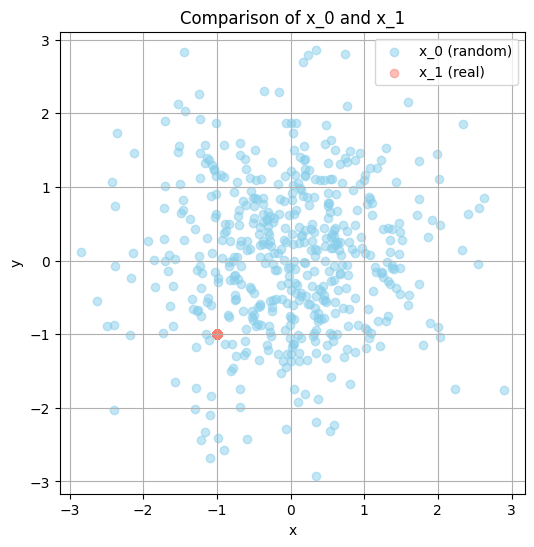

In [ ]:
import matplotlib.pyplot as plt

# Move to CPU for plotting if needed
x_1_np = x_1.float().cpu().numpy()
x_0_np = torch.randn_like(x_1).to(device).cpu().numpy()

plt.figure(figsize=(6, 6))
plt.scatter(x_0_np[:, 0], x_0_np[:, 1], alpha=0.5, label='x_0 (random)', color='skyblue')
plt.scatter(x_1_np[:, 0], x_1_np[:, 1], alpha=0.5, label='x_1 (real)', color='salmon')
plt.legend()
plt.title("Comparison of x_0 and x_1")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.axis('equal')
plt.show()


In [ ]:
#  heat map shows the evolution of points over
# T = T.cpu()

# fig, axs = plt.subplots(1, 10,figsize=(20,20))

# for i in range(10):
#     H= axs[i].hist2d(sol[i,:,0], sol[i,:,1], 300, range=((-10,10), (-10,10)))

#     # cmin = 0.0
#     # cmax = torch.quantile(torch.from_numpy(H[0]), 0.99).item()

#     # norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

#     _ = axs[i].hist2d(sol[i,:,0], sol[i,:,1], 300, range=((-10,10), (-10,10)))

#     axs[i].set_aspect('equal')
#     axs[i].axis('off')
#     axs[i].set_title('t= %.2f' % (T[i]))

# plt.tight_layout()
# plt.show()

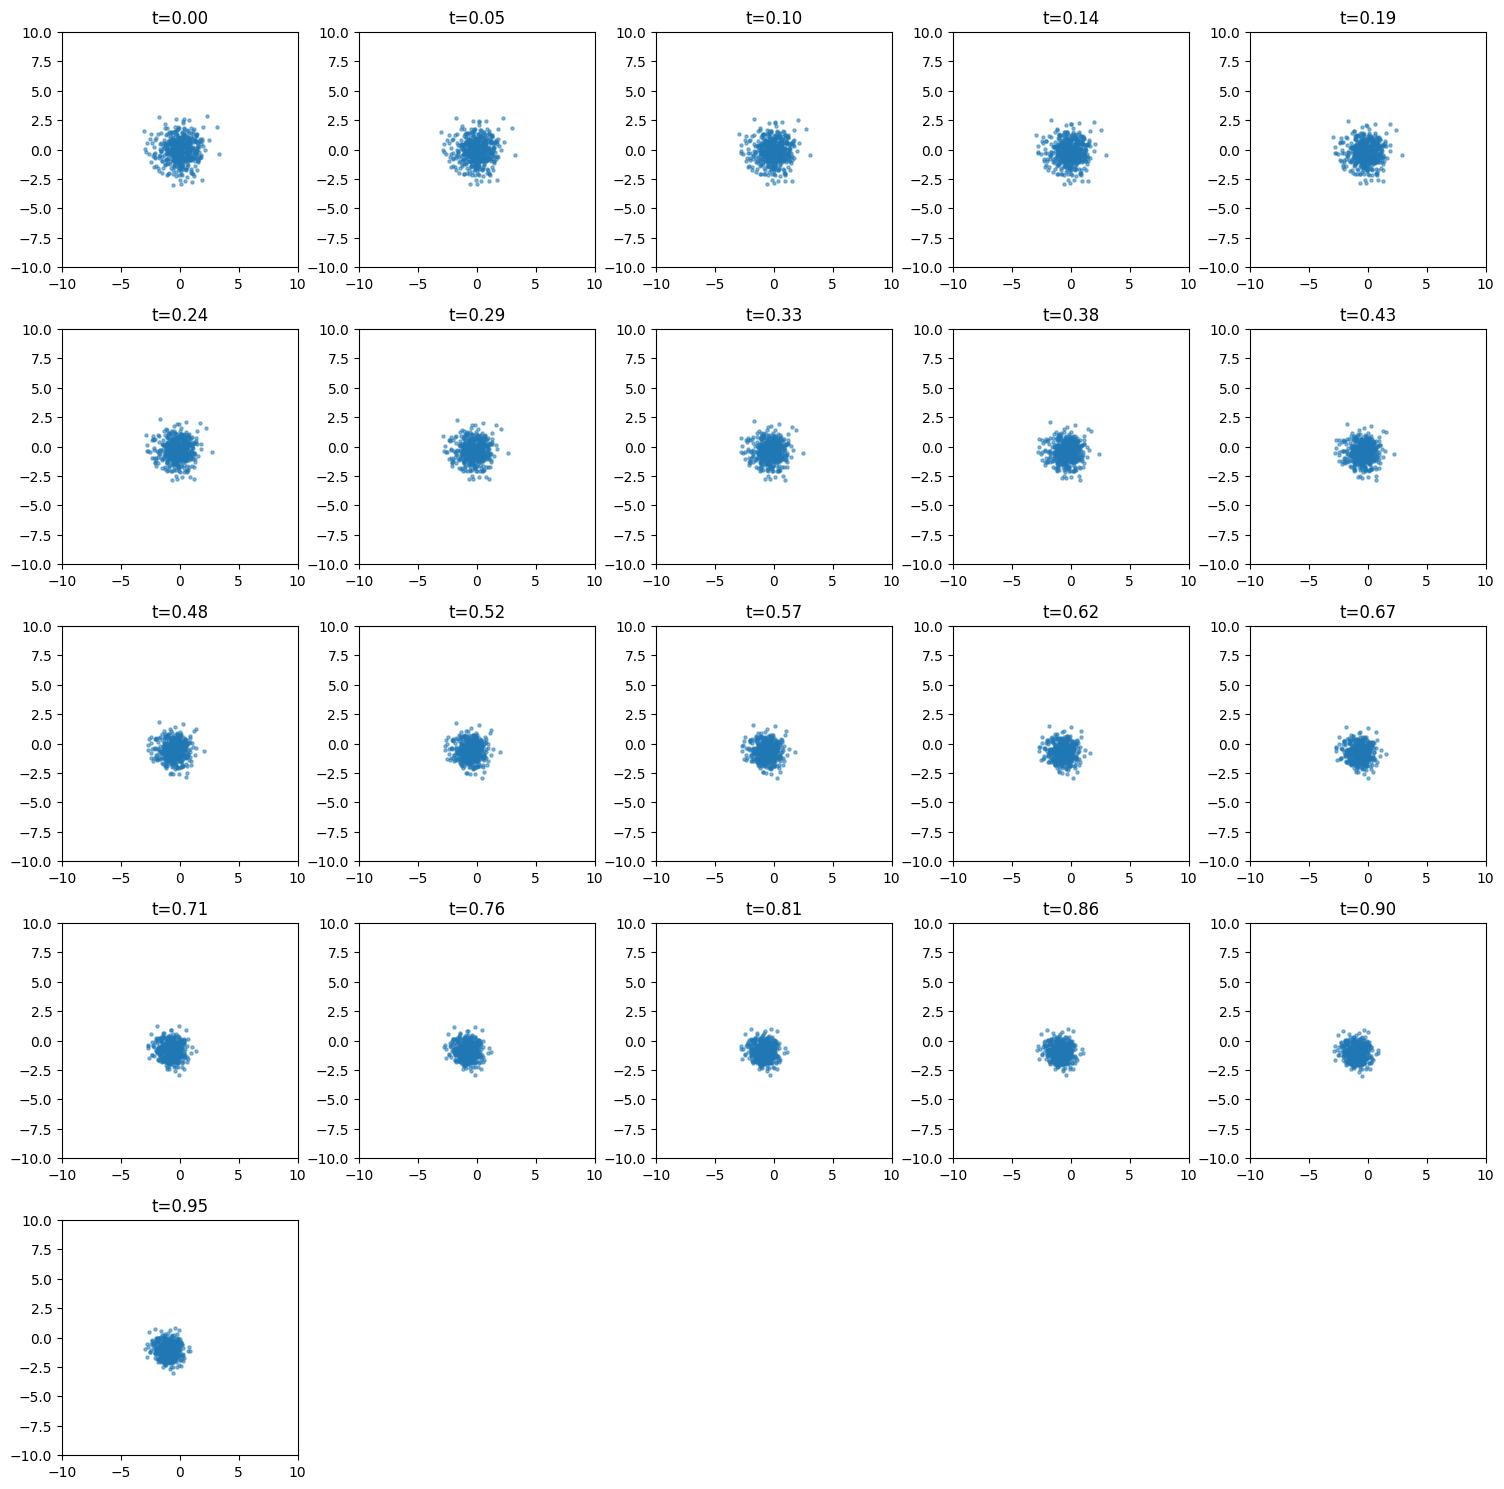

In [ ]:
@torch.no_grad()
def simulate_flow(vf, x0, steps=20, T=1.0):
  x_t = x0.clone()
  traj = [x_t.cpu()]

  for i in range(1, steps + 1):
    t = torch.full((x_t.shape[0],), i/steps*T).to(x_t.device)
    dx = vf(x_t, t)
    dt = T / steps
    x_t = x_t + dx * dt
    traj.append(x_t.cpu())

  return traj

import matplotlib.pyplot as plt
import math

# Get random x0
n_plots = 20
x0 = torch.randn(500, X.shape[1]).to(device)
traj = simulate_flow(vf, x0, steps=n_plots)

rows = 5
cols = math.ceil(n_plots / rows) + 1

# Plot evolution
fig, axs = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
axs = axs.flatten()
for i, xt in enumerate(traj):
    axs[i].scatter(xt[:, 0], xt[:, 1], s=5, alpha=0.5)
    axs[i].set_title(f"t={i/len(traj):.2f}")
    axs[i].axis("on")
    axs[i].set_aspect('equal')
    axs[i].set_xlim(-10, 10)   # fix x-axis limits
    axs[i].set_ylim(-10, 10)   # fix y-axis limits

for j in range(len(traj), len(axs)):
  axs[j].axis("off")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# Convert each step in traj to numpy
traj_np = [x.numpy() for x in traj]

# If images were originally 28x28, reshape
reconstructed_images_reshaped = [img.reshape(-1, 28, 28) for img in traj_np]


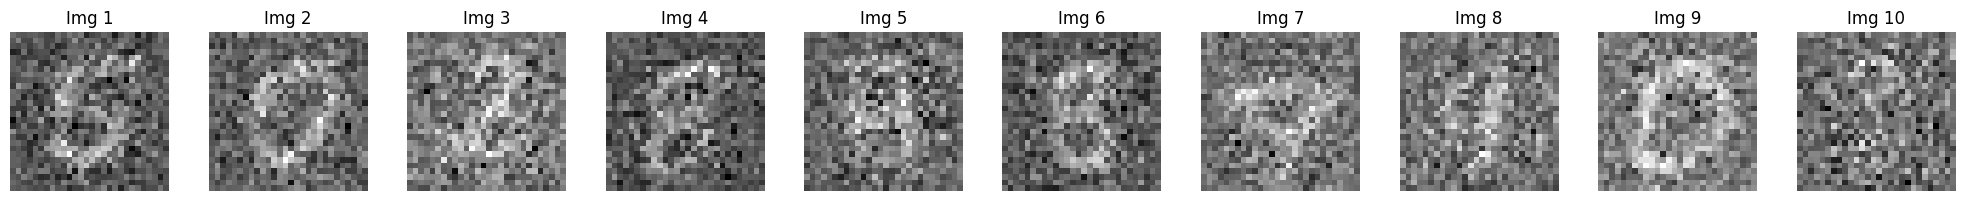

In [ ]:
import matplotlib.pyplot as plt

time_step = 20
num_images = 10
reconstructed_images_reshaped = np.array(reconstructed_images_reshaped)

fig, axs = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
for i in range(num_images):
    axs[i].imshow(reconstructed_images_reshaped[time_step, i], cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f'Img {i+1}')

plt.tight_layout()
plt.show()
